In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset

from torchvision import datasets, transforms, models
from torchvision.transforms import functional as F

from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from matplotlib import pyplot as plt

import os
import sys

In [4]:
# Загружаем CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
data_len = train_dataset.__len__()

In [6]:
# Глобальные параметры
INITIAL_TRAIN = 0.2                        # Начальные данные
BATCH_ADD_SIZE = 1000                       # K данных для добавления
WARMUP_EPOCHS = 5
TOTAL_TRAIN_SIZE = data_len                 # Общее количество тренировочных данных
NUM_CLASSES = 10                            # CIFAR-10

In [7]:
# Задаем пропорцию выборки
p = INITIAL_TRAIN 

# Загрузка данных
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# Группируем индексы по классам
class_indices = {class_idx: [] for class_idx in range(NUM_CLASSES)}
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

# Разделяем данные
initial_indices = []
pool_indices = []

for class_idx, indices in class_indices.items():
    np.random.shuffle(indices)  # Перемешиваем индексы внутри класса
    split_idx = int(len(indices) * p)  # Вычисляем границу разделения
    initial_indices.extend(indices[:split_idx])
    pool_indices.extend(indices[split_idx:])

# Создаем подмножества данных
initial_train_dataset = Subset(train_dataset, initial_indices)
pool_dataset = Subset(train_dataset, pool_indices)

print(f"Размер initial_train_dataset: {len(initial_train_dataset)}")
print(f"Размер pool_dataset: {len(pool_dataset)}")

Files already downloaded and verified
Размер initial_train_dataset: 10000
Размер pool_dataset: 40000


In [8]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from base_trainer import Trainer
from model import SimpleCNN
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), 'EGL')))

In [9]:
class BALDTrainer(Trainer):

    def enable_dropout(self):
        """
        Включает Dropout в модели даже в режиме eval.
        """
        for module in self.model.modules():
            if module.__class__.__name__.startswith('Dropout'):
                module.train()

    def select_samples(self, num_samples):
        """
        Выбирает наиболее информативные примеры из пула данных, используя метод BALD.

        :param num_samples: Количество отбираемых примеров.
        :return: Список индексов информативных примеров.
        """
        self.model.eval()  # Переключаем модель в режим оценки
        self.enable_dropout() # Включаем Dropout для Monte Carlo Dropout
        all_entropies = []  # Список для хранения энтропий каждого примера
        all_indices = []  # Список для хранения индексов примеров

        with torch.no_grad():
            for batch in self.pool_loader:
                inputs, indices = batch  # Предполагается, что loader возвращает данные и их индексы
                inputs = inputs.to(self.device)

                # Monte Carlo Dropout: несколько проходов через модель
                mc_outputs = torch.stack([
                    torch.softmax(self.model(inputs), dim=-1) for _ in range(10)  # 10 итераций MC Dropout
                ])  # (mc_samples, batch_size, num_classes)

                # Среднее предсказание по всем MC итерациям
                mean_probs = mc_outputs.mean(dim=0)  # (batch_size, num_classes)

                # Общая энтропия
                total_entropy = -torch.sum(mean_probs * mean_probs.log(), dim=-1)  # (batch_size)

                # Условная энтропия
                conditional_entropy = -torch.mean(
                    torch.sum(mc_outputs * mc_outputs.log(), dim=-1), dim=0  # (batch_size)
                )

                # Взаимная информация (BALD score)
                bald_scores = total_entropy - conditional_entropy  # (batch_size)

                # Сохраняем результаты
                all_entropies.append(bald_scores.cpu())
                all_indices.append(indices)

        # Объединяем результаты для всех батчей
        all_entropies = torch.cat(all_entropies)  # Все BALD оценки
        all_indices = torch.cat(all_indices)  # Все индексы

        # Отбираем топ-K индексов с наибольшими BALD оценками
        _, top_indices = torch.topk(all_entropies, num_samples)
        informative_indices = all_indices[top_indices].tolist()

        # Обновляем dataloader для следующих итераций
        self.update_dataloader(informative_indices)

        return informative_indices
    
    def update_dataloader(self, samples_index):
        """
        Обновляем даталоудеры
        """
        samples = [self.pool_loader.dataset[i] for i in samples_index]


        new_train_data = ConcatDataset([self.train_loader.dataset, samples])
        
        self.train_loader = DataLoader(new_train_data,
                                       batch_size=self.train_loader.batch_size,
                                       shuffle=True,
                                       num_workers=self.train_loader.num_workers)
        

        all_indexes = list(range(len(self.pool_loader.dataset)))
        
        filtered_indexes = [idx for idx in all_indexes if idx not in samples_index]

        new_pool_data = Subset(self.pool_loader.dataset, filtered_indexes)

        self.pool_loader = DataLoader(new_pool_data,
                                      batch_size=self.pool_loader.batch_size,
                                      shuffle=True,
                                      num_workers=self.pool_loader.num_workers)
    
    def fit(self, num_epochs, num_samples = BATCH_ADD_SIZE):

        """
        Полный цикл обучения.
        :param num_epochs: Количество эпох
        """
        for epoch in range(num_epochs):

            train_loss = self.train_step()
            val_loss, accuracy, f1 = self.val_step()
            if len(self.pool_loader.dataset) > num_samples:
                self.select_samples(num_samples)
            if self.scheduler is not None:
                if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

            
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.4f}, F1: {f1:.4f}")




In [10]:
train_dataloader = DataLoader(initial_train_dataset, batch_size=128, shuffle=True)
pool_dataloader = DataLoader(pool_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [11]:
model = SimpleCNN(10)

In [12]:
EPOCHS = 50
learning_rate = 5e-4
total_steps = len(train_dataloader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=learning_rate )
# from adabelief_pytorch import AdaBelief
# optimizer = AdaBelief(model.parameters(), lr=learning_rate, eps=learning_rate, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=False, rectify=True, print_change_log = False)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate , total_steps=total_steps, pct_start=0.1, anneal_strategy='linear')


In [13]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE


'cuda'

In [14]:
trainer = BALDTrainer(model=model.to(DEVICE), 
                     optimizer=optimizer,
                     criterion=criterion, 
                     train_loader=train_dataloader,
                     val_loader=val_dataloader, 
                     device=DEVICE, 
                     scheduler = None,
                     pool_loader= pool_dataloader)

In [15]:
trainer.fit(EPOCHS)


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.83it/s]


Validation Loss: 3.1731, Accuracy: 0.2179, F1 Score: 0.1662
Epoch 1/50 - Train Loss: 2.0818, Val Loss: 3.1731, Acc: 0.2179, F1: 0.1662


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.50it/s]


Validation Loss: 6.3379, Accuracy: 0.1939, F1 Score: 0.1397
Epoch 2/50 - Train Loss: 1.7384, Val Loss: 6.3379, Acc: 0.1939, F1: 0.1397


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.42it/s]


Validation Loss: 7.2491, Accuracy: 0.1683, F1 Score: 0.1274
Epoch 3/50 - Train Loss: 1.4706, Val Loss: 7.2491, Acc: 0.1683, F1: 0.1274


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.04it/s]


Validation Loss: 7.2738, Accuracy: 0.1961, F1 Score: 0.1582
Epoch 4/50 - Train Loss: 1.3066, Val Loss: 7.2738, Acc: 0.1961, F1: 0.1582


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.68it/s]


Validation Loss: 7.3016, Accuracy: 0.2165, F1 Score: 0.1867
Epoch 5/50 - Train Loss: 1.1822, Val Loss: 7.3016, Acc: 0.2165, F1: 0.1867


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.73it/s]


Validation Loss: 7.7849, Accuracy: 0.2404, F1 Score: 0.1932
Epoch 6/50 - Train Loss: 1.0764, Val Loss: 7.7849, Acc: 0.2404, F1: 0.1932


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.56it/s]


Validation Loss: 7.2778, Accuracy: 0.2723, F1 Score: 0.2267
Epoch 7/50 - Train Loss: 0.9772, Val Loss: 7.2778, Acc: 0.2723, F1: 0.2267


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.95it/s]


Validation Loss: 7.4374, Accuracy: 0.2764, F1 Score: 0.2344
Epoch 8/50 - Train Loss: 0.8728, Val Loss: 7.4374, Acc: 0.2764, F1: 0.2344


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.96it/s]


Validation Loss: 5.7368, Accuracy: 0.3370, F1 Score: 0.2898
Epoch 9/50 - Train Loss: 0.8139, Val Loss: 5.7368, Acc: 0.3370, F1: 0.2898


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.65it/s]


Validation Loss: 7.0406, Accuracy: 0.3043, F1 Score: 0.2642
Epoch 10/50 - Train Loss: 0.7386, Val Loss: 7.0406, Acc: 0.3043, F1: 0.2642


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.11it/s]


Validation Loss: 7.4090, Accuracy: 0.2984, F1 Score: 0.2587
Epoch 11/50 - Train Loss: 0.6992, Val Loss: 7.4090, Acc: 0.2984, F1: 0.2587


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.06it/s]


Validation Loss: 7.5685, Accuracy: 0.3103, F1 Score: 0.2670
Epoch 12/50 - Train Loss: 0.6501, Val Loss: 7.5685, Acc: 0.3103, F1: 0.2670


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.56it/s]


Validation Loss: 6.2221, Accuracy: 0.3582, F1 Score: 0.3202
Epoch 13/50 - Train Loss: 0.6076, Val Loss: 6.2221, Acc: 0.3582, F1: 0.3202


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.56it/s]


Validation Loss: 6.0895, Accuracy: 0.3606, F1 Score: 0.3255
Epoch 14/50 - Train Loss: 0.5677, Val Loss: 6.0895, Acc: 0.3606, F1: 0.3255


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.90it/s]


Validation Loss: 6.8690, Accuracy: 0.3355, F1 Score: 0.3066
Epoch 15/50 - Train Loss: 0.5276, Val Loss: 6.8690, Acc: 0.3355, F1: 0.3066


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.55it/s]


Validation Loss: 6.0372, Accuracy: 0.3834, F1 Score: 0.3564
Epoch 16/50 - Train Loss: 0.4891, Val Loss: 6.0372, Acc: 0.3834, F1: 0.3564


Validating: 100%|██████████| 79/79 [00:02<00:00, 39.49it/s]


Validation Loss: 6.3088, Accuracy: 0.3776, F1 Score: 0.3422
Epoch 17/50 - Train Loss: 0.4607, Val Loss: 6.3088, Acc: 0.3776, F1: 0.3422


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.58it/s]


Validation Loss: 6.8965, Accuracy: 0.3521, F1 Score: 0.3286
Epoch 18/50 - Train Loss: 0.4411, Val Loss: 6.8965, Acc: 0.3521, F1: 0.3286


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.31it/s]


Validation Loss: 6.2787, Accuracy: 0.3784, F1 Score: 0.3558
Epoch 19/50 - Train Loss: 0.4154, Val Loss: 6.2787, Acc: 0.3784, F1: 0.3558


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.94it/s]


Validation Loss: 6.1646, Accuracy: 0.3942, F1 Score: 0.3608
Epoch 20/50 - Train Loss: 0.3923, Val Loss: 6.1646, Acc: 0.3942, F1: 0.3608


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.73it/s]


Validation Loss: 6.3193, Accuracy: 0.3864, F1 Score: 0.3628
Epoch 21/50 - Train Loss: 0.3653, Val Loss: 6.3193, Acc: 0.3864, F1: 0.3628


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.74it/s]


Validation Loss: 6.7850, Accuracy: 0.3724, F1 Score: 0.3494
Epoch 22/50 - Train Loss: 0.3437, Val Loss: 6.7850, Acc: 0.3724, F1: 0.3494


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.93it/s]


Validation Loss: 6.5411, Accuracy: 0.3787, F1 Score: 0.3500
Epoch 23/50 - Train Loss: 0.3275, Val Loss: 6.5411, Acc: 0.3787, F1: 0.3500


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.08it/s]


Validation Loss: 7.7618, Accuracy: 0.3532, F1 Score: 0.3218
Epoch 24/50 - Train Loss: 0.3058, Val Loss: 7.7618, Acc: 0.3532, F1: 0.3218


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.80it/s]


Validation Loss: 6.6036, Accuracy: 0.3851, F1 Score: 0.3600
Epoch 25/50 - Train Loss: 0.2907, Val Loss: 6.6036, Acc: 0.3851, F1: 0.3600


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.54it/s]


Validation Loss: 7.4641, Accuracy: 0.3726, F1 Score: 0.3483
Epoch 26/50 - Train Loss: 0.2719, Val Loss: 7.4641, Acc: 0.3726, F1: 0.3483


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.33it/s]


Validation Loss: 6.8336, Accuracy: 0.3952, F1 Score: 0.3686
Epoch 27/50 - Train Loss: 0.2632, Val Loss: 6.8336, Acc: 0.3952, F1: 0.3686


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.85it/s]


Validation Loss: 6.9001, Accuracy: 0.3983, F1 Score: 0.3751
Epoch 28/50 - Train Loss: 0.2476, Val Loss: 6.9001, Acc: 0.3983, F1: 0.3751


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.77it/s]


Validation Loss: 7.1483, Accuracy: 0.4010, F1 Score: 0.3744
Epoch 29/50 - Train Loss: 0.2323, Val Loss: 7.1483, Acc: 0.4010, F1: 0.3744


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.08it/s]


Validation Loss: 6.5967, Accuracy: 0.4233, F1 Score: 0.3890
Epoch 30/50 - Train Loss: 0.2210, Val Loss: 6.5967, Acc: 0.4233, F1: 0.3890


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.07it/s]


Validation Loss: 7.8759, Accuracy: 0.3900, F1 Score: 0.3557
Epoch 31/50 - Train Loss: 0.2080, Val Loss: 7.8759, Acc: 0.3900, F1: 0.3557


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.87it/s]


Validation Loss: 7.5753, Accuracy: 0.4028, F1 Score: 0.3782
Epoch 32/50 - Train Loss: 0.1977, Val Loss: 7.5753, Acc: 0.4028, F1: 0.3782


Validating: 100%|██████████| 79/79 [00:01<00:00, 40.77it/s]


Validation Loss: 6.9463, Accuracy: 0.4272, F1 Score: 0.4026
Epoch 33/50 - Train Loss: 0.1857, Val Loss: 6.9463, Acc: 0.4272, F1: 0.4026


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.18it/s]


Validation Loss: 7.7367, Accuracy: 0.4099, F1 Score: 0.3873
Epoch 34/50 - Train Loss: 0.1745, Val Loss: 7.7367, Acc: 0.4099, F1: 0.3873


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.13it/s]


Validation Loss: 7.4675, Accuracy: 0.4151, F1 Score: 0.3898
Epoch 35/50 - Train Loss: 0.1660, Val Loss: 7.4675, Acc: 0.4151, F1: 0.3898


Validating: 100%|██████████| 79/79 [00:01<00:00, 41.76it/s]


Validation Loss: 7.6748, Accuracy: 0.4156, F1 Score: 0.3911
Epoch 36/50 - Train Loss: 0.1548, Val Loss: 7.6748, Acc: 0.4156, F1: 0.3911


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.25it/s]


Validation Loss: 7.2385, Accuracy: 0.4391, F1 Score: 0.4126
Epoch 37/50 - Train Loss: 0.1488, Val Loss: 7.2385, Acc: 0.4391, F1: 0.4126


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.08it/s]


Validation Loss: 7.2214, Accuracy: 0.4397, F1 Score: 0.4141
Epoch 38/50 - Train Loss: 0.1443, Val Loss: 7.2214, Acc: 0.4397, F1: 0.4141


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.89it/s]


Validation Loss: 7.7441, Accuracy: 0.4362, F1 Score: 0.4071
Epoch 39/50 - Train Loss: 0.1352, Val Loss: 7.7441, Acc: 0.4362, F1: 0.4071


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.34it/s]


Validation Loss: 8.1111, Accuracy: 0.4302, F1 Score: 0.4100
Epoch 40/50 - Train Loss: 0.1262, Val Loss: 8.1111, Acc: 0.4302, F1: 0.4100


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.08it/s]


Validation Loss: 8.2541, Accuracy: 0.4383, F1 Score: 0.4167
Epoch 41/50 - Train Loss: 0.1221, Val Loss: 8.2541, Acc: 0.4383, F1: 0.4167


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.01it/s]


Validation Loss: 9.0940, Accuracy: 0.4276, F1 Score: 0.3937
Epoch 42/50 - Train Loss: 0.1132, Val Loss: 9.0940, Acc: 0.4276, F1: 0.3937


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.56it/s]


Validation Loss: 8.3367, Accuracy: 0.4428, F1 Score: 0.4114
Epoch 43/50 - Train Loss: 0.1088, Val Loss: 8.3367, Acc: 0.4428, F1: 0.4114


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.23it/s]


Validation Loss: 8.7565, Accuracy: 0.4367, F1 Score: 0.4107
Epoch 44/50 - Train Loss: 0.1026, Val Loss: 8.7565, Acc: 0.4367, F1: 0.4107


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.35it/s]


Validation Loss: 7.8866, Accuracy: 0.4557, F1 Score: 0.4349
Epoch 45/50 - Train Loss: 0.0951, Val Loss: 7.8866, Acc: 0.4557, F1: 0.4349


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.55it/s]


Validation Loss: 9.2235, Accuracy: 0.4383, F1 Score: 0.4094
Epoch 46/50 - Train Loss: 0.0908, Val Loss: 9.2235, Acc: 0.4383, F1: 0.4094


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.94it/s]


Validation Loss: 8.9068, Accuracy: 0.4452, F1 Score: 0.4194
Epoch 47/50 - Train Loss: 0.0858, Val Loss: 8.9068, Acc: 0.4452, F1: 0.4194


Validating: 100%|██████████| 79/79 [00:01<00:00, 42.46it/s]


Validation Loss: 9.5348, Accuracy: 0.4516, F1 Score: 0.4164
Epoch 48/50 - Train Loss: 0.0840, Val Loss: 9.5348, Acc: 0.4516, F1: 0.4164


Validating: 100%|██████████| 79/79 [00:01<00:00, 43.75it/s]


Validation Loss: 9.2645, Accuracy: 0.4512, F1 Score: 0.4151
Epoch 49/50 - Train Loss: 0.0788, Val Loss: 9.2645, Acc: 0.4512, F1: 0.4151


Validating: 100%|██████████| 79/79 [00:01<00:00, 44.29it/s]


Validation Loss: 10.4889, Accuracy: 0.4277, F1 Score: 0.4053
Epoch 50/50 - Train Loss: 0.0734, Val Loss: 10.4889, Acc: 0.4277, F1: 0.4053


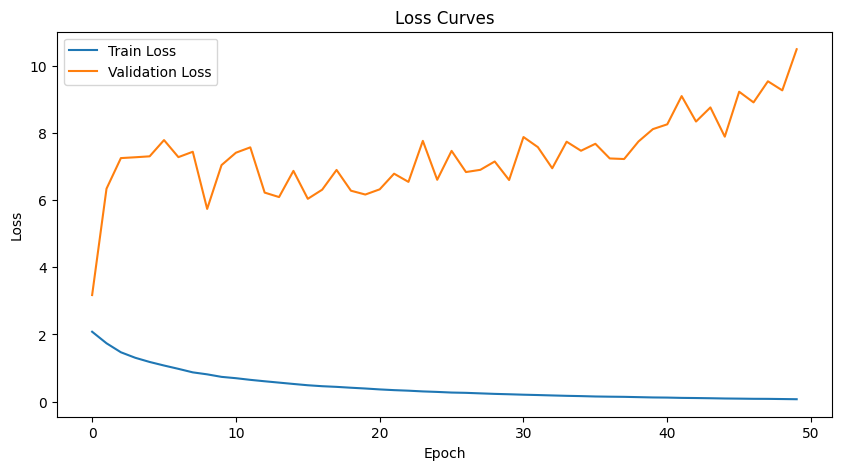

In [16]:
trainer.plot_losses()

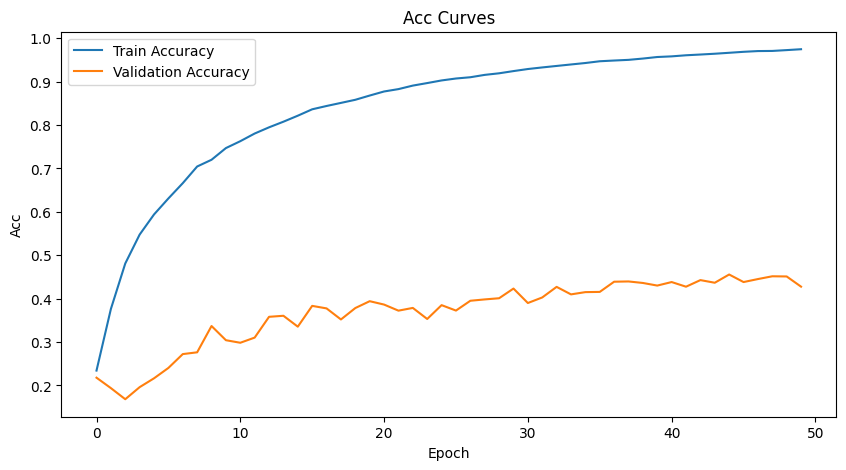

In [17]:
trainer.plot_acc()

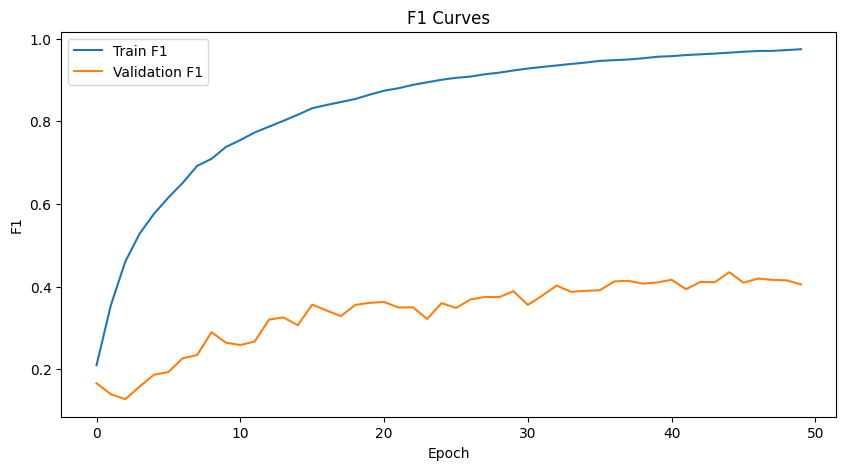

In [18]:
trainer.plot_f1()

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))


In [ ]:
from base_trainer import Trainer

In [ ]:
trainer = Trainer(model=model.to(DEVICE), optimizer=optimizer,criterion=criterion, train_loader=train_dataloader, val_loader=val_dataloader, device=DEVICE, scheduler = scheduler)

In [ ]:
trainer.fit(5)

Validating: 100%|██████████| 157/157 [00:02<00:00, 77.56it/s]


Validation Loss: 1.1971, Accuracy: 0.5813, F1 Score: 0.5716
Epoch 1/5 - Train Loss: 1.4456, Val Loss: 1.1971, Acc: 0.5813, F1: 0.5716


Validating: 100%|██████████| 157/157 [00:02<00:00, 78.22it/s]


Validation Loss: 1.0325, Accuracy: 0.6368, F1 Score: 0.6324
Epoch 2/5 - Train Loss: 1.1362, Val Loss: 1.0325, Acc: 0.6368, F1: 0.6324


Validating: 100%|██████████| 157/157 [00:02<00:00, 77.56it/s]


Validation Loss: 0.9409, Accuracy: 0.6731, F1 Score: 0.6702
Epoch 3/5 - Train Loss: 1.0026, Val Loss: 0.9409, Acc: 0.6731, F1: 0.6702


Validating: 100%|██████████| 157/157 [00:02<00:00, 76.66it/s]


Validation Loss: 0.8854, Accuracy: 0.6921, F1 Score: 0.6893
Epoch 4/5 - Train Loss: 0.9173, Val Loss: 0.8854, Acc: 0.6921, F1: 0.6893


Validating: 100%|██████████| 157/157 [00:02<00:00, 76.14it/s]


Validation Loss: 0.8437, Accuracy: 0.7077, F1 Score: 0.7050
Epoch 5/5 - Train Loss: 0.8472, Val Loss: 0.8437, Acc: 0.7077, F1: 0.7050


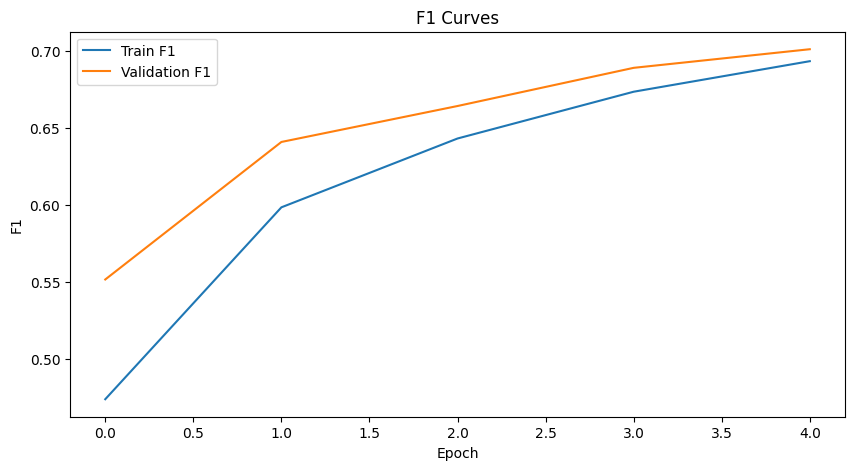

In [ ]:
trainer.plot_f1()